# **Experiment Notebook**



In this experiment, logistic regression is used to predict NBA draft outcomes by analyzing player data such as performance metrics and physical attributes, estimating the likelihood of a player being drafted or not.

### 0. Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

# installing my pypi package
!pip3 install -i https://test.pypi.org/simple/ my_krml_24886400==2024.0.0.5

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from my_krml_24886400.data.sets import pop_target, data_cleaning, roc_curve_plot, distribution_plot, categorical_plot, relationship_plot

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
#  set path of the data
train_file_url = '../data/raw/train.csv'
test_file_url = '../data/raw/test.csv'

In [5]:
# read the csv data
train_df = pd.read_csv(train_file_url)
test_df = pd.read_csv(test_file_url)

In [6]:
# checking the shape of the data
train_df.shape, test_df.shape

((46618, 64), (4970, 63))

### 1. Explore Data Using Pypi

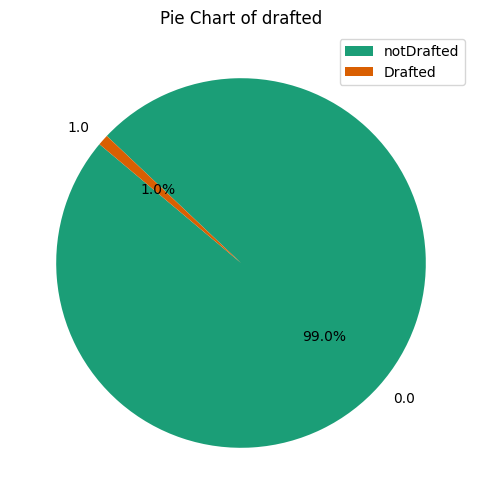

In [7]:
# Using the distribution_plot funciton from pypi package
distribution_plot(kind='piechart', df = train_df, x = 'drafted')
plt.legend(['notDrafted', 'Drafted'])
plt.show()

The pie chart illustrates the distribution of drafted versus undrafted players. The overwhelming majority, 99%, of the players in the dataset are notDrafted, while only 1% are Drafted.

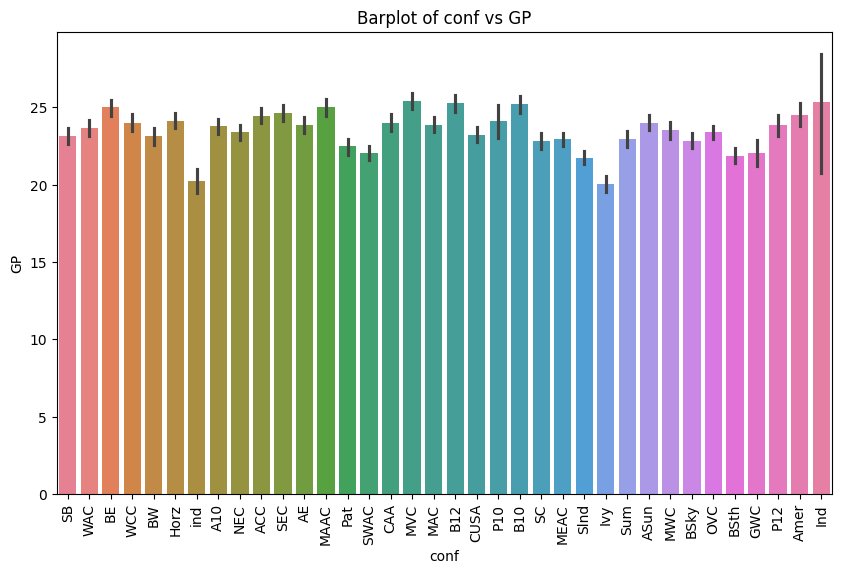

In [8]:
# Using the categorical_plot funciton from pypi package
categorical_plot(kind="barplot", x="conf", y="GP", df=train_df, hue="conf")
plt.show()

- Most conferences have a relatively similar average number of games played, generally ranging between 20 and 25 games.
- Some conferences, such as BE and Ind (Independent), stand out with slightly higher average games played, approaching or exceeding 25 games.
- Other conferences, such as WAC and SB, have slightly lower averages, around 20 games.

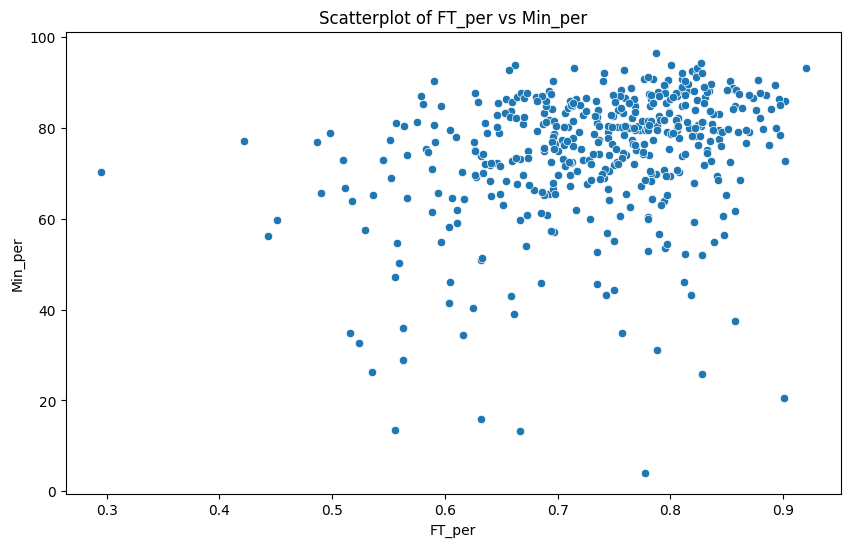

In [9]:
# Using the relationship_plot funciton from pypi package
relationship_plot(df=train_df[train_df['drafted'] == 1], kind="scatterplot", x='FT_per', y='Min_per')

- There’s a positive correlation between free throw percentage and minutes played. Players with higher free throw percentages, especially those between 0.6 and 0.9, tend to play more, with minutes ranging from 60 to 100.
- Players with lower free throw percentages (below 0.5) show more variation in their minutes, with some playing as few as 20 minutes and others up to 80 minutes.
- The cluster of points in the upper-right corner suggests that players who are better at free throw shooting generally get more consistent playing time.


### 3. Preparing Data

In [10]:
# prepare data cleaning
df_cleaned = train_df.copy()
df_clean_test = test_df.copy()

In [11]:
# drop Irrelevant Features
df_cleaned.drop(columns=['player_id', 'year', 'team'], inplace=True)
df_clean_test.drop(columns=['player_id', 'year', 'team'], inplace=True)

# dropping columns with a large amount of missing data (e.g., Rec_Rank)
df_cleaned.drop('Rec_Rank', axis=1, inplace=True)
df_clean_test.drop('Rec_Rank', axis=1, inplace=True)

In [12]:
# height transformation:
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def convert_height(ht_value):
    try:
        feet, inches = ht_value.split('-')
        inches = month_mapping.get(inches, inches)  # Convert month-like string to a number
        return int(feet) * 12 + int(inches)
    except (ValueError, AttributeError):
        return np.nan

In [13]:
# Listing num and cat cols
num_cols = ['ast_tov', 'rimmade', 'midmade', 'rim_ratio', 'mid_ratio', 'dunks_ratio', 'pick']
cat_cols = ['num', 'ht', 'yr']

In [14]:
# Data cleanig using Pypi function
df_cleaned = data_cleaning(df_cleaned, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})
X_test = data_cleaning(df_clean_test, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})

In [15]:
# split the data into features and target
X, y = pop_target(df_cleaned, 'drafted')

In [16]:
# further split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
# define the preprocessing pipeline
categorical_columns = ['conf', 'yr', 'type']  # Adjust as needed
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [18]:
# create the Logistic Regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

### Model Training and Evaluation

In [19]:
# train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'ht',
                                                   'porpag', 'adjoe', 'pfr',
                                                   'ast_tov', 'rimmade',
                                                   'rimmade_rimmiss', 'midmade', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['conf', 'yr', 'type'])])),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [20]:
# predict on the train set
y_pred = pipeline.predict(X_train)
y_pred_proba = pipeline.predict_proba(X_train)[:, 1]  # Get the probability estimates for the positive class

In [21]:
# predict on the val set
y_pred_val = pipeline.predict(X_val)
y_pred_proba_val = pipeline.predict_proba(X_val)[:, 1]  # Get the probability estimates for the positive class

In [22]:
# ROC AUC Score
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9920


In [23]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9917


The ROC auc score seems to be decent in this model and performing well

In [24]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     32321
         1.0       0.74      0.41      0.52       311

    accuracy                           0.99     32632
   macro avg       0.87      0.70      0.76     32632
weighted avg       0.99      0.99      0.99     32632



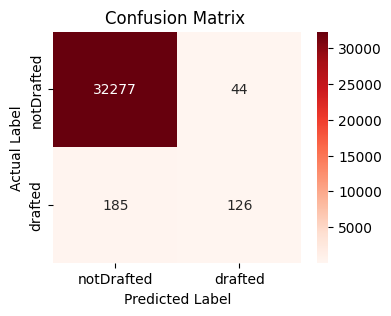

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix ')
plt.show()

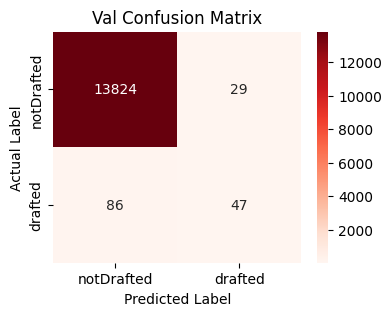

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Val Confusion Matrix')
plt.show()

The model shows strong accuracy in predicting "notDrafted" players but consistently struggles with correctly classifying "drafted" players, indicating a need for improvement in handling minority classes.

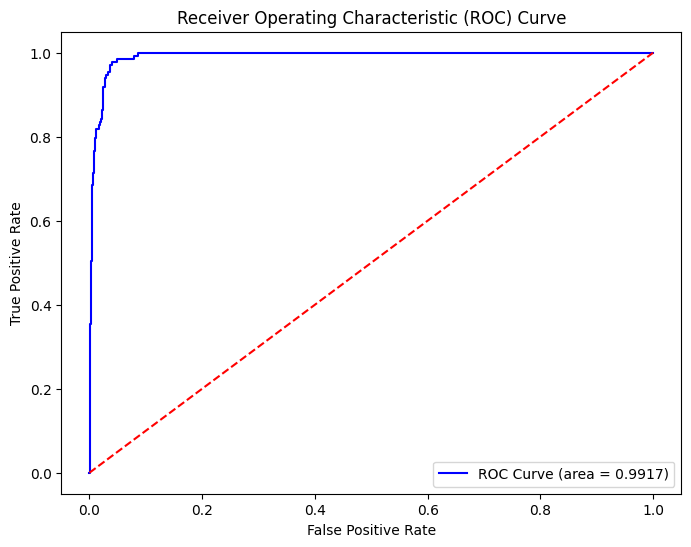

In [27]:
# Plot ROC Curve
roc_curve_plot(y_val, y_pred_proba_val)

 the model performs well overall, as indicated by the ROC curve with an area under the curve (AUC) of 0.9917, which suggests that the model has excellent discriminatory ability between the "drafted" and "notDrafted" classes

With a test score of 0.988 and an AUC of 0.9917, the model demonstrates exceptional overall performance, confirming its ability to generalize well on unseen data. However, the confusion matrices highlight a recurring issue

In [28]:
# Create the Logistic Regression pipeline
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, C=0.1))
])

In [29]:
# 5. Train the model
pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'ht',
                                                   'porpag', 'adjoe', 'pfr',
                                                   'ast_tov', 'rimmade',
                                                   'rimmade_rimmiss', 'midmade', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['conf', 'yr', 'type'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])

In [30]:
# Predict on the test set
y_pred_1 = pipeline_1.predict(X_train)
y_pred_proba_1 = pipeline_1.predict_proba(X_train)[:, 1]  # Get the probability estimates for the positive class

In [31]:
# predict on the test set
y_pred_val_1 = pipeline_1.predict(X_val)
y_pred_proba_val_1 = pipeline_1.predict_proba(X_val)[:, 1]  # Get the probability estimates for the positive class

In [32]:
# ROC AUC Score
roc_auc = roc_auc_score(y_train, y_pred_proba_1)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9904


In [33]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val_1)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9907


In [34]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred_1))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     32321
         1.0       0.76      0.33      0.46       311

    accuracy                           0.99     32632
   macro avg       0.88      0.67      0.73     32632
weighted avg       0.99      0.99      0.99     32632



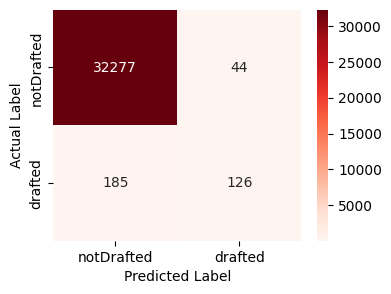

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

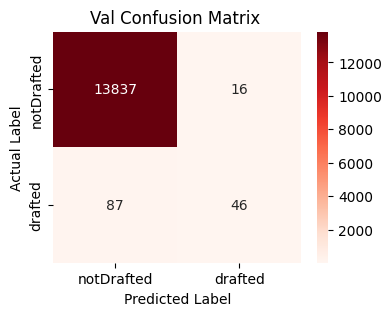

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val_1)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Val Confusion Matrix ')
plt.show()

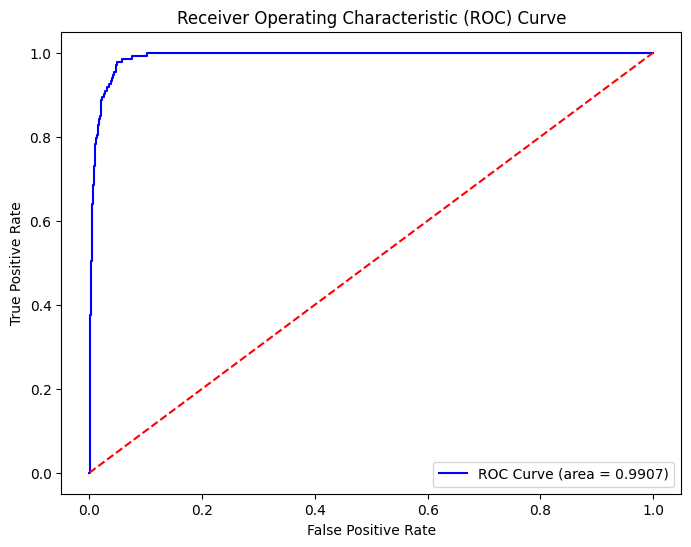

In [37]:
roc_curve_plot(y_val, y_pred_proba_val_1)

In [38]:
# Create the Logistic Regression pipeline
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000, C=0.01))
])

In [39]:
# Train the model
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'ht',
                                                   'porpag', 'adjoe', 'pfr',
                                                   'ast_tov', 'rimmade',
                                                   'rimmade_rimmiss', 'midmade', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['conf', 'yr', 'type'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=10000, random_state=42))])

In [40]:
# Predict on the test set
y_pred_2 = pipeline_2.predict(X_train)
y_pred_proba_2 = pipeline_2.predict_proba(X_train)[:, 1]  # Get the probability estimates for the positive class

In [41]:
# Predict on the test set
y_pred_val_2 = pipeline_2.predict(X_val)
y_pred_proba_val_2 = pipeline_2.predict_proba(X_val)[:, 1]  # Get the probability estimates for the positive class

In [42]:
# ROC AUC Score
roc_auc = roc_auc_score(y_train, y_pred_proba_2)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9840


In [43]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val_2)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9853


In [44]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred_2))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     32321
         1.0       0.73      0.24      0.36       311

    accuracy                           0.99     32632
   macro avg       0.86      0.62      0.68     32632
weighted avg       0.99      0.99      0.99     32632



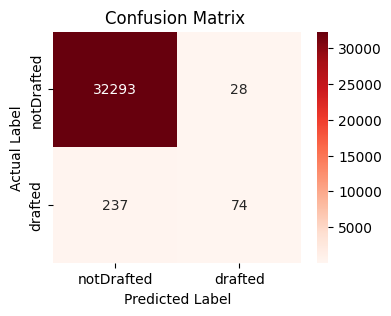

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred_2)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix ')
plt.show()

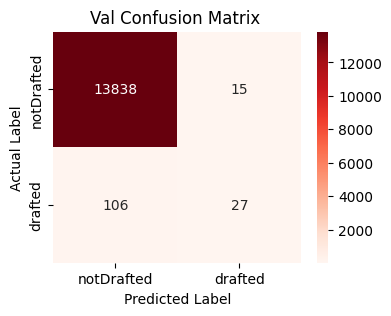

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val_2)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Val Confusion Matrix ')
plt.show()

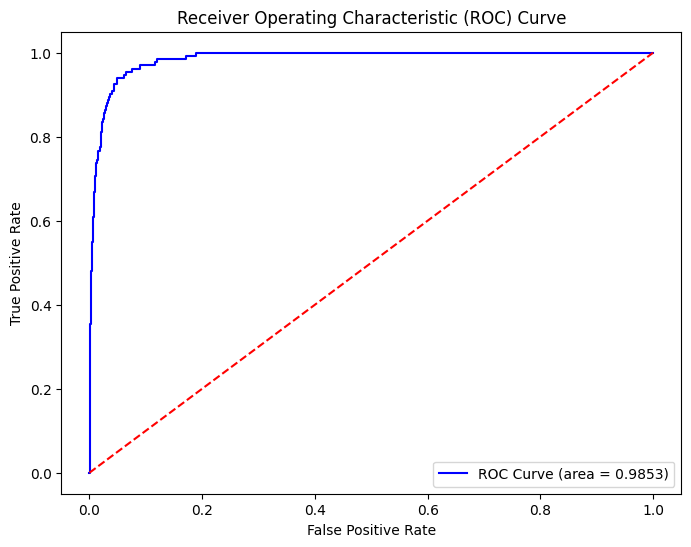

In [47]:
roc_curve_plot(y_val, y_pred_proba_val_2)

In [48]:
test_df['predicted_probability'] = pipeline.predict_proba(X_test)[:,1]
test_df[['player_id', 'predicted_probability']].to_csv('submission.csv', index=False)

In [49]:
test_df[['player_id', 'predicted_probability']].head()

,player_id,predicted_probability
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,4.138592e-09
1,52a518bb-b34a-4b43-adee-5e996cb853fa,8.829088e-08
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,5.417346e-05
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,2.104133e-06
4,55d07491-5bd1-447f-844e-9cb36eaa442e,2.282503e-03


With an AUC of 0.9917 and a test score of 0.988 with best model in this experiment, the model shows excellent overall performance, indicating strong ability to distinguish between "drafted" and "notDrafted" players. However, the confusion matrices highlight a recurring issue of struggles to correctly identify "drafted" players